# Technology focus: MEFFISH
This notebook will present a rough overview of the plotting functionalities that `spatialdata` implements for MERFISH data.

## Loading the data
Please download the data from here: [MERFISH dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/merfish.zip) and adjust the variable containing the location of the `.zarr` file.


In [1]:
merfish_zarr_path = "./merfish.zarr"

In [3]:
import spatialdata as sd

merfish_sdata = sd.read_zarr(merfish_zarr_path)
merfish_sdata

SpatialData object with:
├── Images
│     └── 'rasterized': SpatialImage[cyx] (1, 522, 575)
├── Points
│     └── 'single_molecule': DataFrame with shape: (3714642, 3) (2D points)
├── Shapes
│     ├── 'anatomical': GeoDataFrame shape: (6, 1) (2D shapes)
│     └── 'cells': GeoDataFrame shape: (2399, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 2399 × 268
    obs: 'cell_id', 'region'
    uns: 'spatialdata_attrs': AnnData (2399, 268)
with coordinate systems:
▸ 'global', with elements:
        rasterized (Images), single_molecule (Points), anatomical (Shapes), cells (Shapes)

## Visualise the data
We're going to create a naiive visualisation of the data, overlaying the annotated anatomical regions contained in `anatomical` and the tissue image. For this, we need to load the `spatialdata_plot` library which extends the `sd.SpatialData` object with the `.pl` module. Furthermore, we will only select the elements we want to plot using `pp.get_elements()`.

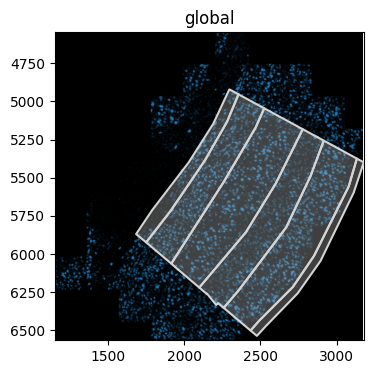

In [4]:
import spatialdata_plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=1, figsize=(4, 4))
(
    merfish_sdata
    .pp.get_elements(["anatomical", "rasterized"])
    .pl.render_images()
    .pl.render_shapes()
    .pl.show(ax=ax)
)


However, the MERFISH data also contains points which we have so far not visualised. This can be done with the `pl.render_points()` function. However, since we have over 3 million points, we will only render 1 % of them as to not overplot the image.

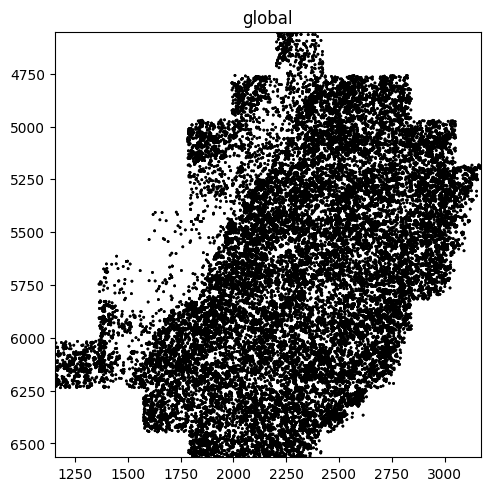

In [5]:
merfish_sdata.points["single_molecule"] = merfish_sdata.points["single_molecule"].sample(frac=0.01)
merfish_sdata.pl.render_points().pl.show()

Furthermore, we can overlay all 3 layers and color the points by an annotation.

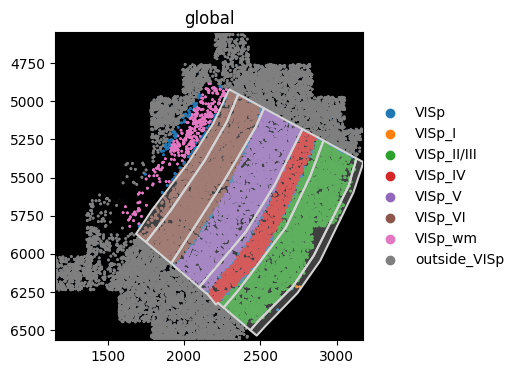

In [6]:
fig, ax = plt.subplots(ncols=1, figsize=(4, 4))
(
    merfish_sdata
    .pp.get_elements(["anatomical", "rasterized", "single_molecule"])
    .pl.render_images()
    .pl.render_points(color="cell_type")
    .pl.render_shapes()
    .pl.show(ax=ax)
)